In [46]:
import numpy as np
import os
import matlab.engine
import matplotlib.pyplot as plt
from Camera_util import parse_video, parse_mean_video
import pandas as pd
from natsort import natsorted
import time
import Camera_util 
import importlib
import pickle
import scipy.io
import heapq

Generating TTF : 0NDF
Reading in 200FPS 0NDF videos...
Reading 0NDF 3.0hz from 200FPS_3.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_3.0hz_0NDF_settingsHistory.pkl
Reading 0NDF 50.0hz from 200FPS_50.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_50.0hz_0NDF_settingsHistory.pkl
Reading 0NDF 12.0hz from 200FPS_12.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_12.0hz_0NDF_settingsHistory.pkl
Reading 0NDF 0.2hz from 200FPS_0.2hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_0.2hz_0NDF_settingsHistory.pkl
Reading 0NDF 25.0hz from 200FPS_25.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_25.0hz_0NDF_settingsHistory.pkl
Reading 0NDF 1.0hz from 200FPS_1.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_wa

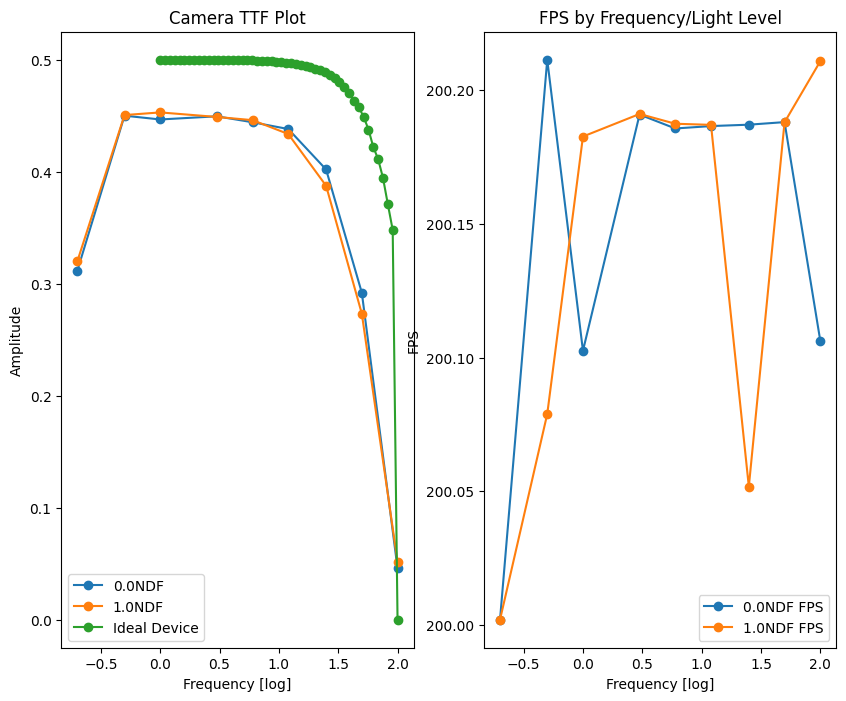

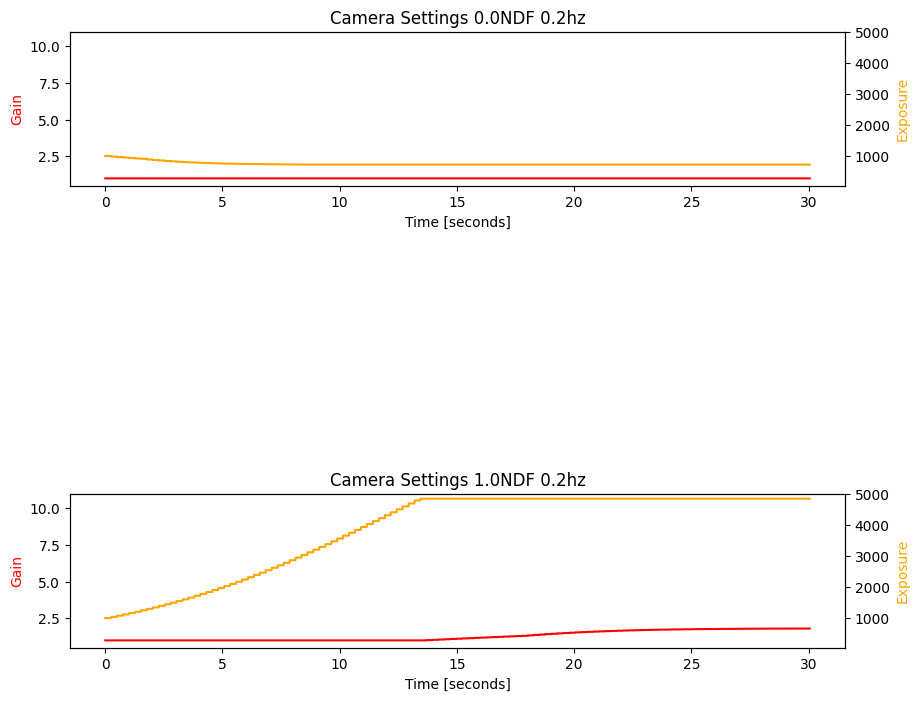

In [67]:
importlib.reload(Camera_util)
recordings_dir = '/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_data/recordings'
experiment_name = '200FPS'
light_levels = [str(i) for i in range(2)]
#Camera_util.generate_ms_by_exposure_plot(recordings_dir, light_levels)
Camera_util.generate_TTF(recordings_dir, experiment_name, light_levels)